# Testing Optimizer with graph models in KGCNN

In [1]:
import numpy as np
import keras as ks

In [2]:
from kgcnn.data.datasets.ESOLDataset import ESOLDataset
dataset = ESOLDataset()
# dataset.set_attributes()
dataset.map_list(method="set_edge_indices_reverse");
dataset.map_list(method="count_nodes_and_edges");
dataset.map_list(method="count_nodes_and_edges", total_edges="total_reverse");

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name ESOL
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.ESOL:Found SDF C:\Users\patri\.kgcnn\datasets\ESOL\delaney-processed.sdf of pre-computed structures.
INFO:kgcnn.data.ESOL:Read molecules from mol-file.
INFO:kgcnn.data.ESOL: ... process molecules 0 from 1128
INFO:kgcnn.molecule.encoder:OneHotEncoder Symbol found ['O', 'C', 'N', 'S', 'Cl', 'P', 'F', 'I', 'Br']
INFO:kgcnn.molecule.encoder:OneHotEncoder Hybridization found [rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP, rdkit.Chem.rdchem.HybridizationType.SP2]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalDegree found [2, 4, 1, 3]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalNumHs found [1, 2, 0, 3, 4]
INFO:kgcnn.molecule.encoder:OneHotEncoder CIPCode found [None, 'S', 'R'

In [3]:
from kgcnn.literature.DMPNN import make_model

In [4]:
model_config = {
    "name": "DMPNN",
    "inputs": [
        {"shape": [None, 41], "name": "node_attributes", "dtype": "float32"},
        {"shape": [None, 11], "name": "edge_attributes", "dtype": "float32"},
        {"shape": [None, 2], "name": "edge_indices", "dtype": "int64"},
        {"shape": [None, 1], "name": "edge_indices_reverse", "dtype": "int64"},
        {"shape": (), "name": "total_nodes", "dtype": "int64"},
        {"shape": (), "name": "total_edges", "dtype": "int64"},
        {"shape": (), "name": "total_reverse", "dtype": "int64"}
    ],
    "cast_disjoint_kwargs": {},
    "input_node_embedding": {"input_dim": 95, "output_dim": 64},
    "input_edge_embedding": {"input_dim": 5, "output_dim": 64},
    "pooling_args": {"pooling_method": "scatter_sum"},
    "edge_initialize": {"units": 128, "use_bias": True, "activation": "relu"},
    "edge_dense": {"units": 128, "use_bias": True, "activation": "linear"},
    "edge_activation": {"activation": "relu"},
    "node_dense": {"units": 128, "use_bias": True, "activation": "relu"},
    "verbose": 10, "depth": 5,
    "dropout": {"rate": 0.1},
    "output_embedding": "graph",
    "output_mlp": {
        "use_bias": [True, True, False], "units": [64, 32, 1],
        "activation": ["relu", "relu", "linear"]
    }
}
# Test making model
model = make_model(**model_config)

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}, {'shape': (), 'name': 'total_reverse', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'cast_disjoint_kwargs': {}, 'input_embedding': None, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 5, 'output_dim': 64}, 'input_graph_embedding': {'input_dim': 100, 'output_dim': 64}, 'pooling_args': {'pooling_method': 'scatter_sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activatio

In [5]:
dataset.clean(model_config["inputs"])

INFO:kgcnn.data.ESOL:Property 'edge_attributes' is an empty list for graph '934'.
INFO:kgcnn.data.ESOL:Property 'edge_indices' is an empty list for graph '934'.
INFO:kgcnn.data.ESOL:Property 'edge_indices_reverse' is an empty list for graph '934'.


array([934])

In [6]:
labels = np.expand_dims(dataset.get("graph_labels"), axis=-1)
labels.shape

(1127, 1)

In [7]:
from copy import deepcopy
from sklearn.model_selection import train_test_split
from keras.backend import clear_session

In [8]:
from kgcnn.optimizers.optimizers import Adan
from keras.optimizers import Adam, SGD, Adamax, Adadelta

In [9]:
train_index, test_index = train_test_split(np.arange(len(dataset)), test_size=0.25, random_state=42)
x_train, y_train = dataset[train_index].tensor(model_config["inputs"]), labels[train_index]
x_valid, y_valid = dataset[test_index].tensor(model_config["inputs"]), labels[test_index]

In [10]:
hist_opt = []
# Adan
opt_selection = [
    Adan(), Adam(), 
    SGD(), Adamax(), Adadelta()]

for opt in opt_selection:
    model = make_model(**model_config)
    
    print(opt)
    model.compile(
        loss="mean_absolute_error",
        optimizer=opt,
        metrics=["mean_absolute_error"],
    )
    # Build model with data.
    model.predict(x_valid, batch_size=2, steps=2)
    model._compile_metrics.build(y_valid, y_valid)
    model._compile_loss.build(y_valid, y_valid)
    hist_run = model.fit(
        x_train,
        y_train,
        validation_data=(x_valid, y_valid),
        shuffle=True,
        batch_size=32,
        epochs=300,
        verbose=0
    )
    hist_opt.append(hist_run)

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}, {'shape': (), 'name': 'total_reverse', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'cast_disjoint_kwargs': {}, 'input_embedding': None, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 5, 'output_dim': 64}, 'input_graph_embedding': {'input_dim': 100, 'output_dim': 64}, 'pooling_args': {'pooling_method': 'scatter_sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activatio

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 


INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}, {'shape': (), 'name': 'total_reverse', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'cast_disjoint_kwargs': {}, 'input_embedding': None, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 5, 'output_dim': 64}, 'input_graph_embedding': {'input_dim': 100, 'output_dim': 64}, 'pooling_args': {'pooling_method': 'scatter_sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activatio

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}, {'shape': (), 'name': 'total_reverse', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'cast_disjoint_kwargs': {}, 'input_embedding': None, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 5, 'output_dim': 64}, 'input_graph_embedding': {'input_dim': 100, 'output_dim': 64}, 'pooling_args': {'pooling_method': 'scatter_sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activatio

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}, {'shape': (), 'name': 'total_reverse', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'cast_disjoint_kwargs': {}, 'input_embedding': None, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 5, 'output_dim': 64}, 'input_graph_embedding': {'input_dim': 100, 'output_dim': 64}, 'pooling_args': {'pooling_method': 'scatter_sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activatio

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}, {'shape': (), 'name': 'total_reverse', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'cast_disjoint_kwargs': {}, 'input_embedding': None, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 5, 'output_dim': 64}, 'input_graph_embedding': {'input_dim': 100, 'output_dim': 64}, 'pooling_args': {'pooling_method': 'scatter_sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activatio

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


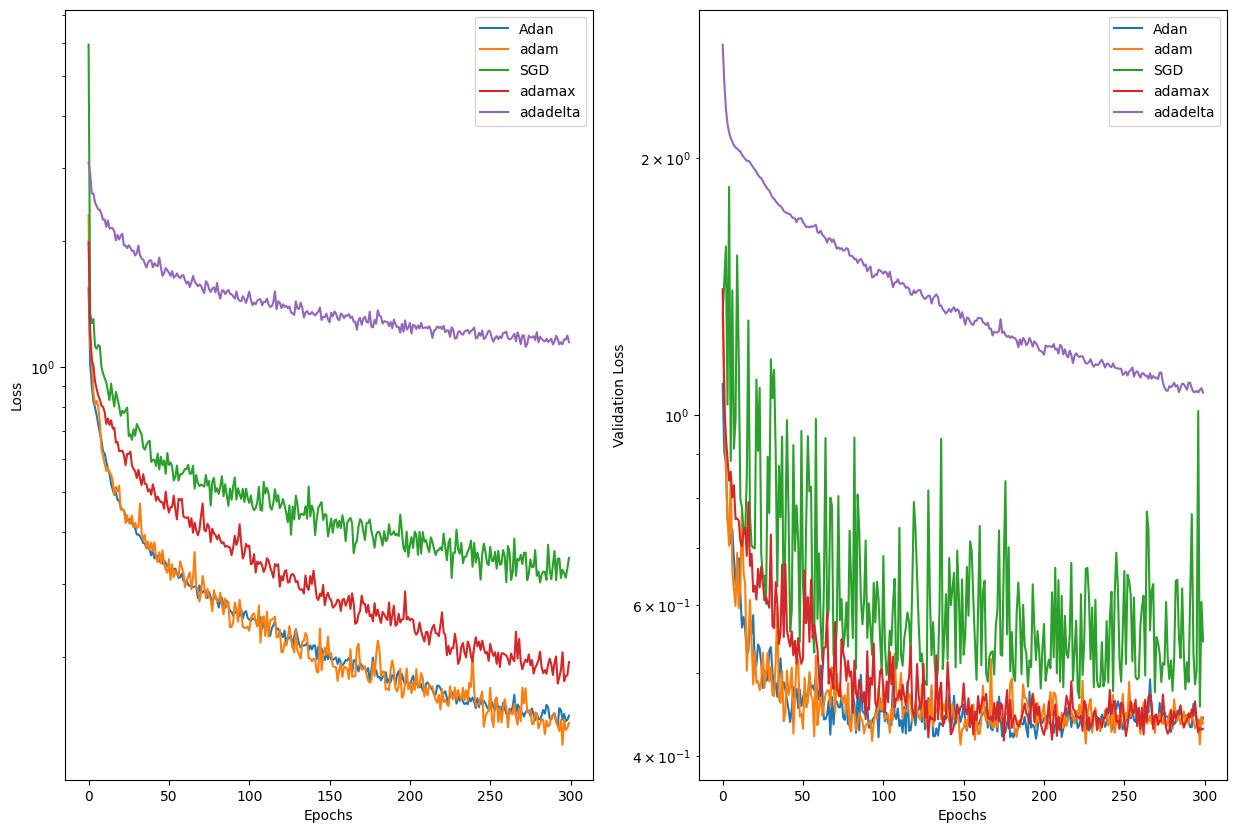

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15,10))
for hist_run, opt in zip(hist_opt, opt_selection):
    axs[0].plot(hist_run.history["loss"], label=opt.get_config()["name"])
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_yscale("log")
    axs[0].legend()
for hist_run, opt in zip(hist_opt, opt_selection):
    axs[1].plot(hist_run.history["val_loss"], label=opt.get_config()["name"])
    axs[1].set_ylabel("Validation Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].set_yscale("log")
    axs[1].legend()

In [12]:
confs = [x.get_config() for x in opt_selection]
confs;